In [2]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [3]:
file_path = '../data/calendar.csv.gz'

with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        df = pd.read_csv(file)


listings = pd.read_csv("../data/listings_cleaned.csv")

In [4]:
df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2595,2023-10-02,f,$240.00,$240.00,30.0,1125.0
1,2595,2023-10-03,f,$240.00,$240.00,30.0,1125.0
2,2595,2023-10-04,f,$240.00,$240.00,30.0,1125.0
3,2595,2023-10-05,f,$240.00,$240.00,30.0,1125.0
4,2595,2023-10-06,f,$240.00,$240.00,30.0,1125.0


In [5]:
df['date'].nunique()

366

In [6]:
df['available'] = df['available'].replace({'f': 0, 't': 1})

In [7]:
# Create a mask of where 'price' and 'adjusted_price' are different
mask = df['price'] != df['adjusted_price']

# Count the number of True values in the mask, which correspond to rows where the values are different
number_of_different_rows = mask.sum()

print(f'The number of rows where price and adjusted_price are different is: {number_of_different_rows} of {len(df)}')

The number of rows where price and adjusted_price are different is: 295075 of 14159104


In [8]:
# Remove the dollar sign and convert the price column to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [9]:
# Remove the dollar sign and convert the price column to float
df['adjusted_price'] = df['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)

In [10]:
# Calculate the absolute difference between 'price' and 'adjusted_price'
difference = (df['price'] - df['adjusted_price']).abs()

# Find the maximum difference
max_difference = difference.max()

print(f'The maximum difference between "price" and "adjusted_price" is: {max_difference}')

The maximum difference between "price" and "adjusted_price" is: 1500.0


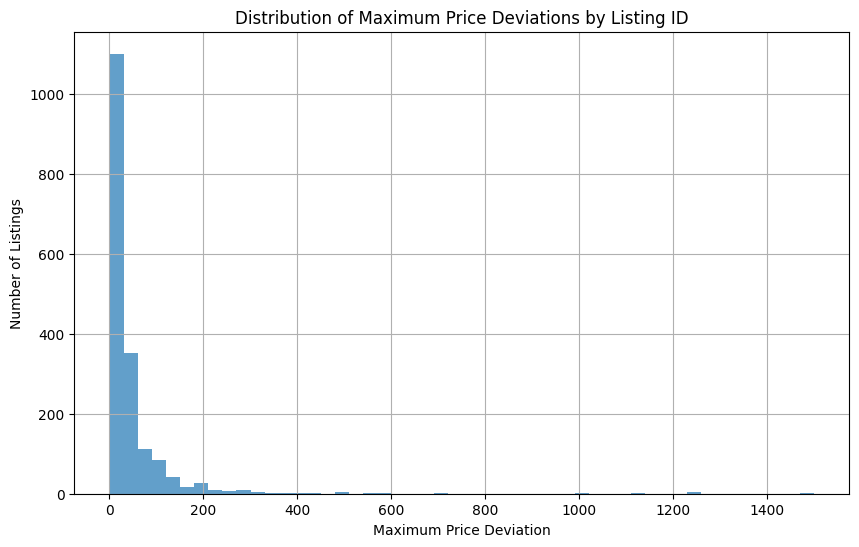

In [25]:
# Calculate the absolute difference between 'price' and 'adjusted_price'
df['price_difference'] = (df['price'] - df['adjusted_price']).abs()

# Group by 'listing_id' and get the maximum price difference for each
max_diff_per_listing = df.groupby('listing_id')['price_difference'].max().reset_index()

# Remove listings with no difference
max_diff_per_listing = max_diff_per_listing[max_diff_per_listing['price_difference'] != 0]

# Now plot the distribution of max price differences
plt.figure(figsize=(10, 6))
plt.hist(max_diff_per_listing['price_difference'], bins=50, alpha=0.7)
plt.title('Distribution of Maximum Price Deviations by Listing ID')
plt.xlabel('Maximum Price Deviation')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.show()

In [11]:
# Group the DataFrame by 'listing_id' and check if 'minimum_nights' has more than one unique value
grouped = df.groupby('listing_id')['minimum_nights'].nunique()

# 'grouped' will be a Series where the index is 'listing_id' and the value is the number of unique 'minimum_nights'
# We are interested in listing_ids where this count is greater than 1, which means there are different 'minimum_nights'
listing_ids_with_different_minimum_nights = grouped[grouped > 1]

# The number of listing_ids with different 'minimum_nights'
number_of_listing_ids = len(listing_ids_with_different_minimum_nights)

print(f'The number of listing_ids with non-uniform minimum_nights is: {number_of_listing_ids}')

The number of listing_ids with non-uniform minimum_nights is: 2051


In [12]:
# Group the DataFrame by 'listing_id' and calculate the range of 'minimum_nights' for each group
grouped = df.groupby('listing_id')['minimum_nights'].agg(lambda x: x.max() - x.min())

# Filter out 'listing_id's that have no change in 'minimum_nights'
changed_listings = grouped[grouped > 0]

# Find the maximum change in 'minimum_nights'
max_change = changed_listings.max()

# Optional: Get the 'listing_id' with the maximum change in 'minimum_nights'
listing_with_max_change = changed_listings.idxmax()

print(f'The maximum change in minimum_nights across all listing_ids is: {max_change}')
print(f'The listing_id with the maximum change in minimum_nights is: {listing_with_max_change}')

The maximum change in minimum_nights across all listing_ids is: 969.0
The listing_id with the maximum change in minimum_nights is: 37812226


In [13]:
# Group the DataFrame by 'listing_id' and aggregate the min and max of 'minimum_nights'
grouped = df.groupby('listing_id')['minimum_nights'].agg(['min', 'max'])

# Calculate the range of change
grouped['change'] = grouped['max'] - grouped['min']

# Filter to only include those listings with changes in 'minimum_nights'
changed_listings = grouped[grouped['change'] > 0]

# Sort the DataFrame by the 'change' column in descending order to see the largest changes first
changed_listings_sorted = changed_listings.sort_values(by='change', ascending=False)

# You may choose to drop the 'change' column if you only need to see the min and max values
changed_listings_sorted = changed_listings_sorted.drop(columns='change')

print(changed_listings_sorted)

                     min    max
listing_id                     
37812226            30.0  999.0
40571315            30.0  999.0
39970059            30.0  999.0
771020423813768188  30.0  500.0
54344780            30.0  500.0
...                  ...    ...
693388387787638582   2.0    3.0
37082885             1.0    2.0
36581537             1.0    2.0
35901159             1.0    2.0
49046672             1.0    2.0

[2051 rows x 2 columns]


In [14]:
# Group the DataFrame by 'listing_id' and sum the 'available' column
availability_counts = df.groupby('listing_id')['available'].sum()

# Convert the Series back to a DataFrame, if you want to work with it as a DataFrame
availability_counts_df = availability_counts.reset_index()

# Rename the columns to be more descriptive
availability_counts_df.columns = ['listing_id', 'availability_sum']

In [15]:
# Merge the dataframes on 'id' from 'listings' and 'listing_id' from 'df'
merged_df = listings.merge(availability_counts_df, left_on='id', right_on='listing_id', how='left')

In [16]:
short_df = merged_df[['id', 'availability_365', 'listing_id', 'availability_sum']]
short_df.head()

,id,availability_365,listing_id,availability_sum
0,9630344,364,9630344,364
1,3533741,0,3533741,0
2,9731039,0,9731039,0
3,21736164,0,21736164,0
4,22280002,96,22280002,96


In [17]:
# Check if both columns are the same for all rows
columns_are_same = (merged_df['availability_365'] == merged_df['availability_sum']).all()

print(f'Are the "availability_365" and "availability_sum" columns the same for all rows? {columns_are_same}')

Are the "availability_365" and "availability_sum" columns the same for all rows? False


In [18]:
# Filter the rows where 'availability_365' and 'availability_sum' are not equal
different_rows = merged_df[merged_df['availability_365'] != merged_df['availability_sum']]

# Get unique values from the 'availability_sum' column in these rows
unique_availability_sum = different_rows['availability_sum'].unique()

print(f'Unique values of "availability_sum" for non-equal rows are: {unique_availability_sum}')

Unique values of "availability_sum" for non-equal rows are: [163 128  10 235  79 146 289 275 299 246 316 255 323 274 139 352 254 362
 108 248 338 365 227  88 326  59  47  42 124  37  68 298 366 233  43 153
  86 341 339 355 131 292 327  62 262 162 357 213 134 220   7 194 330  72
 270 286 318 148  71 273 174 344 251 111  91 336  40 144 321 155  65 143
 334 302 232 322  18 281 353 118 149  52 317  57 346 265  27 296 294 225
 360 176 245  87 142  89 335 354 157 198 241]


In [19]:
# Check if there are any NaN values in the 'availability_sum' column
has_nans = merged_df['availability_sum'].isna().any()

print(f'Does the "availability_sum" column have NaN values? {has_nans}')

Does the "availability_sum" column have NaN values? False


In [20]:
short_df['id'].nunique()

38787

In [21]:
# Filter the DataFrame for rows where 'availability_365' and 'availability_sum' are not equal
non_equal_df = merged_df[merged_df['availability_365'] != merged_df['availability_sum']]

# Get unique listing_ids from the filtered DataFrame
unique_listing_ids = non_equal_df['listing_id'].unique()
print(f'Number of unique listing_ids where availabilities are not equal: {len(unique_listing_ids)}')

# For each unique listing_id, calculate and print the difference between 'availability_365' and 'availability_sum'
for listing_id in unique_listing_ids:
    listing_rows = non_equal_df[non_equal_df['listing_id'] == listing_id]
    for index, row in listing_rows.iterrows():
        difference = abs(row['availability_365'] - row['availability_sum'])
        print(f'Listing ID {listing_id} - Difference: {difference}')

Number of unique listing_ids where availabilities are not equal: 127
Listing ID 22588755 - Difference: 163
Listing ID 862529439916218400 - Difference: 128
Listing ID 51262232 - Difference: 10
Listing ID 949476979798816167 - Difference: 235
Listing ID 870808328899205925 - Difference: 79
Listing ID 736489736032125540 - Difference: 146
Listing ID 13808 - Difference: 289
Listing ID 549362079534421010 - Difference: 275
Listing ID 752124066836971423 - Difference: 299
Listing ID 951759957468338794 - Difference: 246
Listing ID 52934351 - Difference: 316
Listing ID 970049716780027750 - Difference: 255
Listing ID 45816695 - Difference: 323
Listing ID 44801335 - Difference: 274
Listing ID 32616393 - Difference: 139
Listing ID 42203409 - Difference: 352
Listing ID 53132475 - Difference: 254
Listing ID 51907134 - Difference: 362
Listing ID 42982980 - Difference: 108
Listing ID 34278935 - Difference: 248
Listing ID 877602226028132663 - Difference: 338
Listing ID 578923571089407152 - Difference: 365


In [22]:
short_df.loc[short_df['id'] == 877602226028132663]

,id,availability_365,listing_id,availability_sum
9215,877602226028132663,0,877602226028132663,338
